In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import seaborn as sns
import pandas as pd

In [2]:
# Configuration
sns.set()
plt.rcParams.update({
    'figure.figsize': (4*1.8, 3*1.8),
    'figure.dpi': 300,
    'font.family': 'serif',
    'font.serif': ['Computer Modern Roman'],
    'text.usetex': True,
    'text.latex.preamble': [
        r'\usepackage{siunitx}',
        r'\usepackage{physics}',
        r'\usepackage{amsmath}'
    ]
})
%config InlineBackend.figure_format = 'retina'

In [3]:
#data_led = pd.read_csv('led.txt', '\t').values
#data_akf = pd.read_csv('akf.txt', '\t').values
#data_op = pd.read_csv('current.txt', '\t').values
ledvi = pd.read_csv('led_v_i.txt', '\t').values
afk_on = pd.read_csv('fet_id_uds_ugs5.txt', '\t').values
afk_off = pd.read_csv('fet_id_uds_ugs0.txt', '\t').values
operation = pd.read_csv('operation.txt', '\t').values

In [4]:
led_v = interp1d(ledvi[:, 0], ledvi[:, 1])
fet_id = interp1d(afk_off[:, 0], afk_off[:, 1])
fet_v = 5
i_d = 0

points = np.zeros((4, 2))

for i in range(4):
    print(f"{i_d:.5e} {5 - fet_v:.5e} {fet_v:.5e}")
    points[i, :] = np.r_[[fet_v, i_d]]
    i_d = fet_id(fet_v)
    fet_v = 5 - led_v(i_d)

0.00000e+00 0.00000e+00 5.00000e+00
4.16767e-08 8.85961e-01 4.11404e+00
3.42928e-08 8.78990e-01 4.12101e+00
3.43509e-08 8.79051e-01 4.12095e+00


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


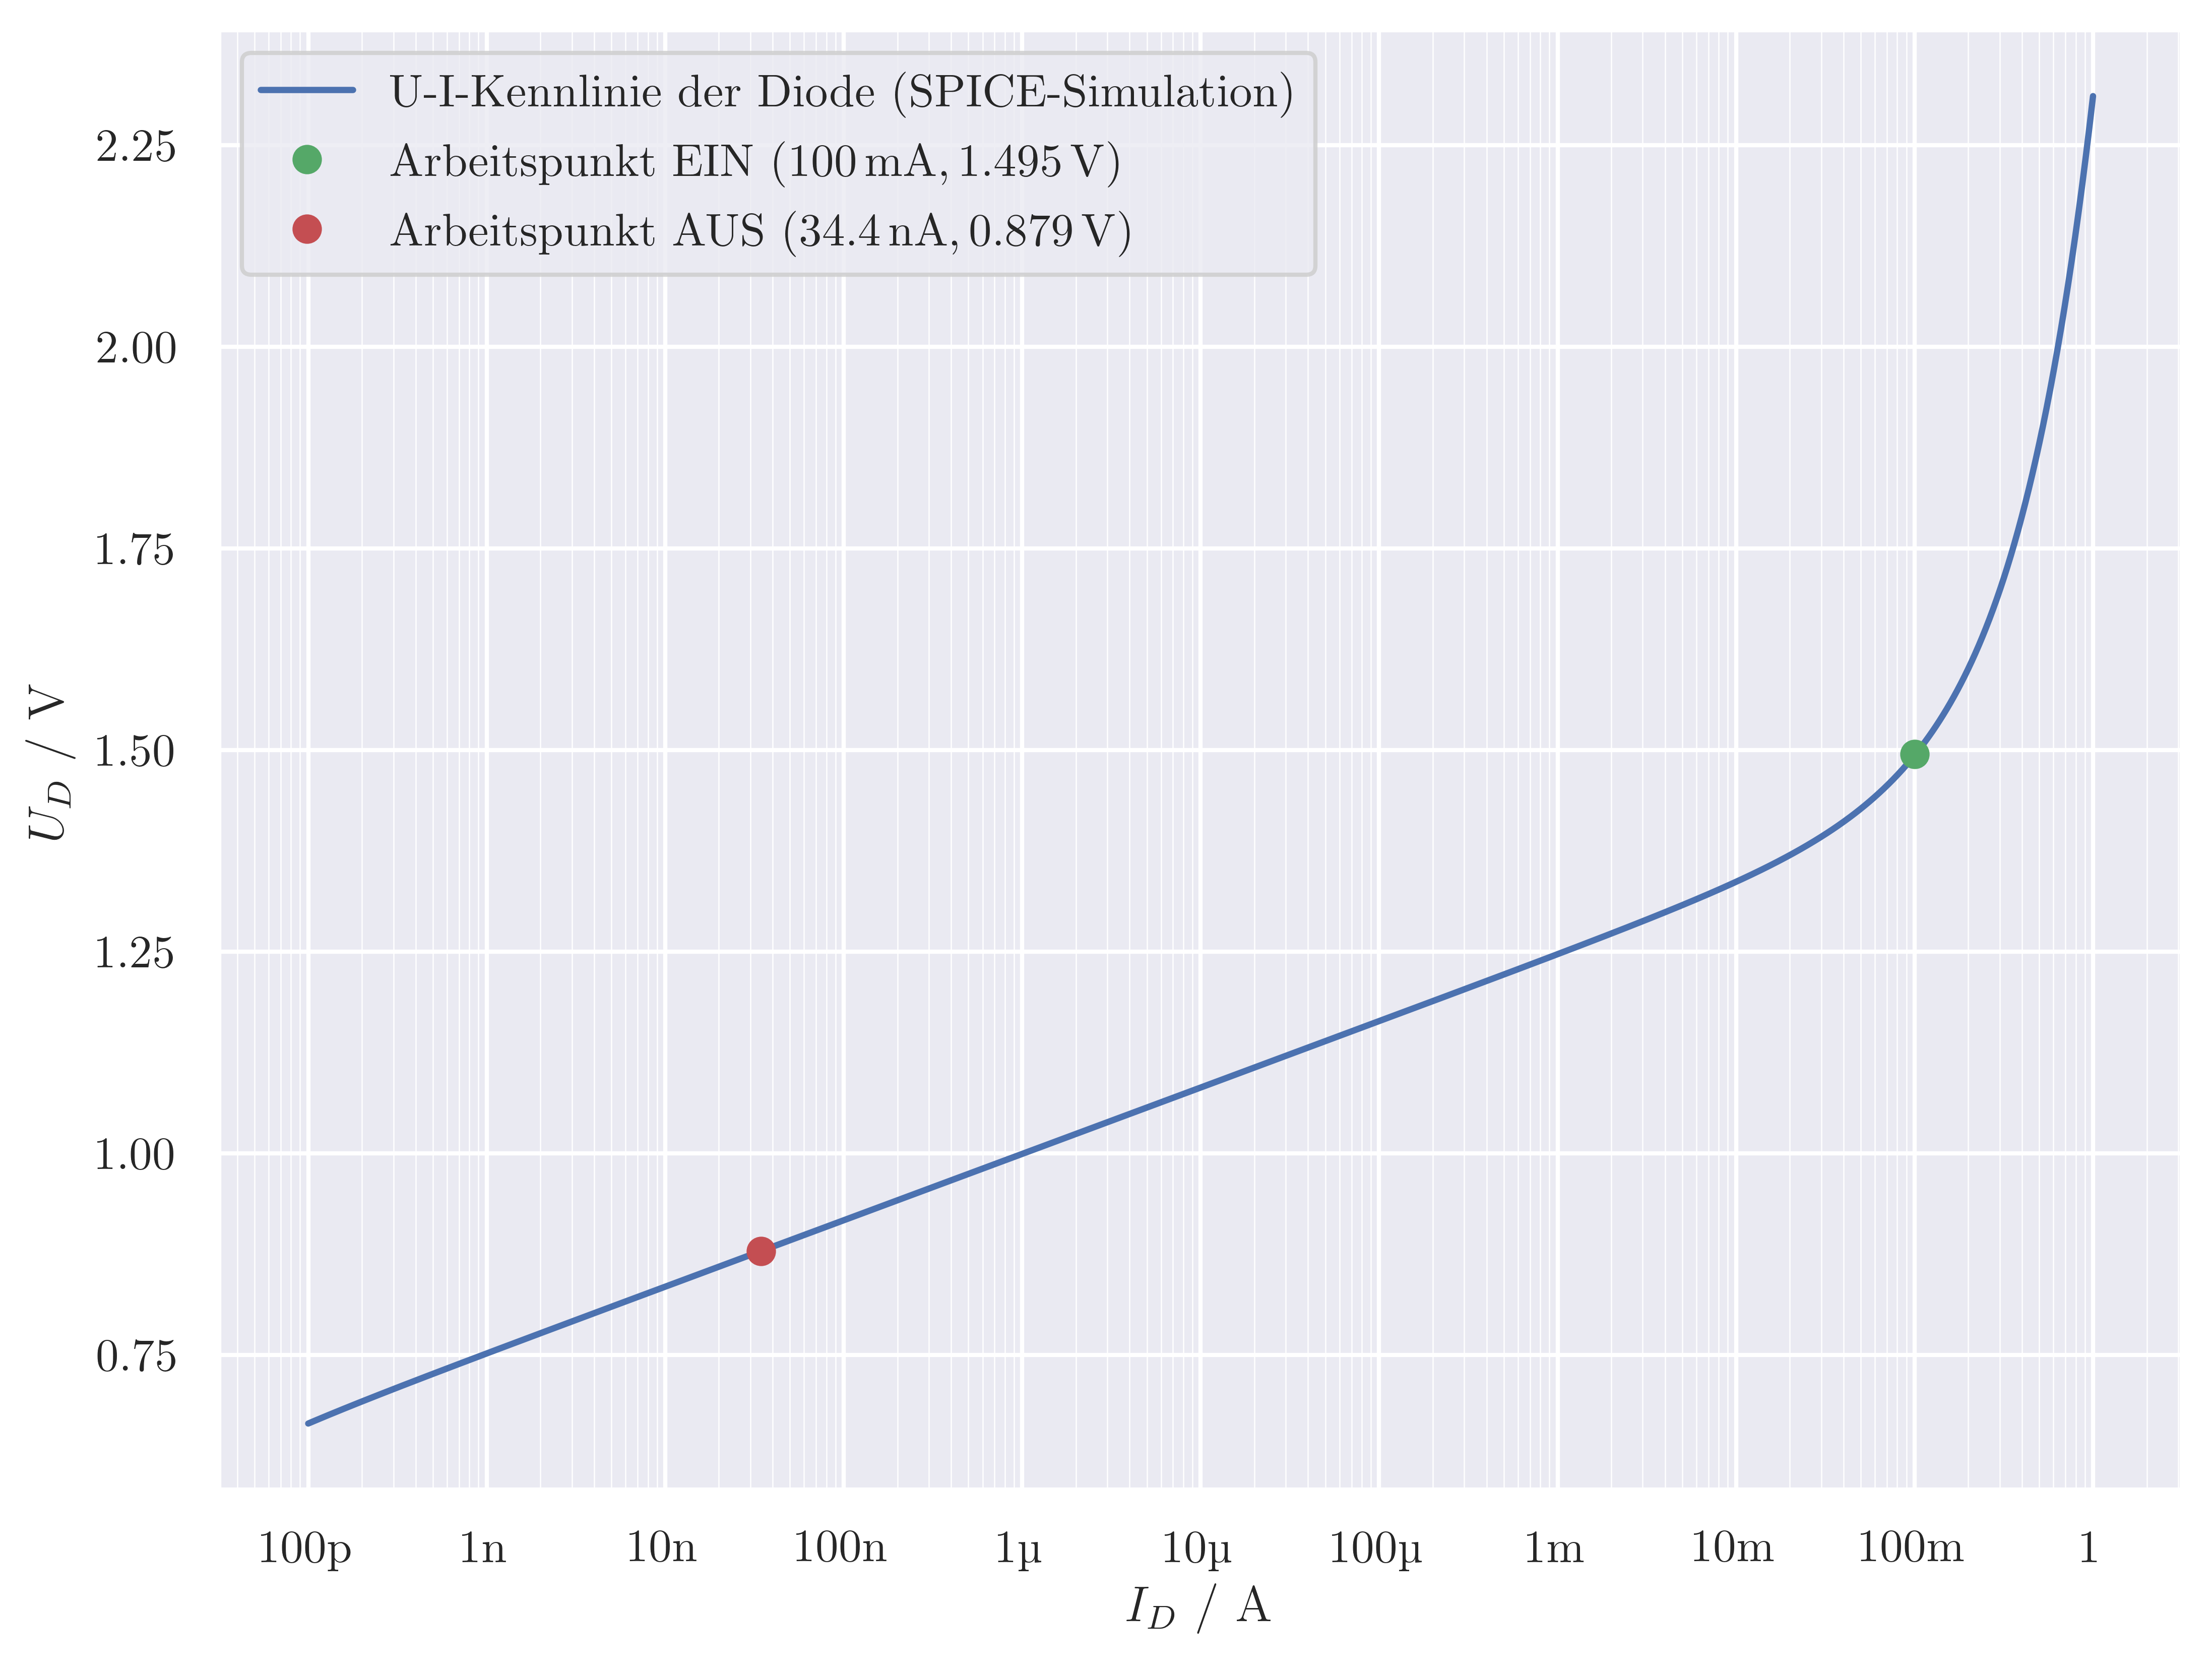

In [5]:
# LED Arbeitspunkt
fig, ax = plt.subplots(constrained_layout=True)
ax.semilogx(ledvi[:, 0], ledvi[:, 1], label="U-I-Kennlinie der Diode (SPICE-Simulation)")
ax.plot([0.1], [1.495], 'go', label=r'Arbeitspunkt EIN $(\SI{100}{\mA}, \SI{1.495}{\V})$')
ax.plot(points[-1][1], 5 - points[-1][0], 'ro', label=r'Arbeitspunkt AUS $(\SI{34.4}{\nA}, \SI{0.879}{\V})$')
#ax.set_yticks(np.arange(1, 2.4, .1))
ax.set(xlabel='$I_D$ / A', ylabel='$U_D$ / V')#, title=r"Bestimmung des Arbeitspunkts der LED "\
                                              #       r"($I_{\text{max}} = \SI{100}{\mA}$)")
ax.set_xticks(10.**np.arange(-10, 1))
ax.xaxis.grid(True, which='minor', linewidth=.3)
ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10. ,subs=(.1, .2, .3, .4, .5, .6, .7, .8, .9), numticks=12))
ax.xaxis.set_major_formatter(EngFormatter(places=0, sep=""))
ax.legend()
#fig.tight_layout()
fig.savefig('AP.png')

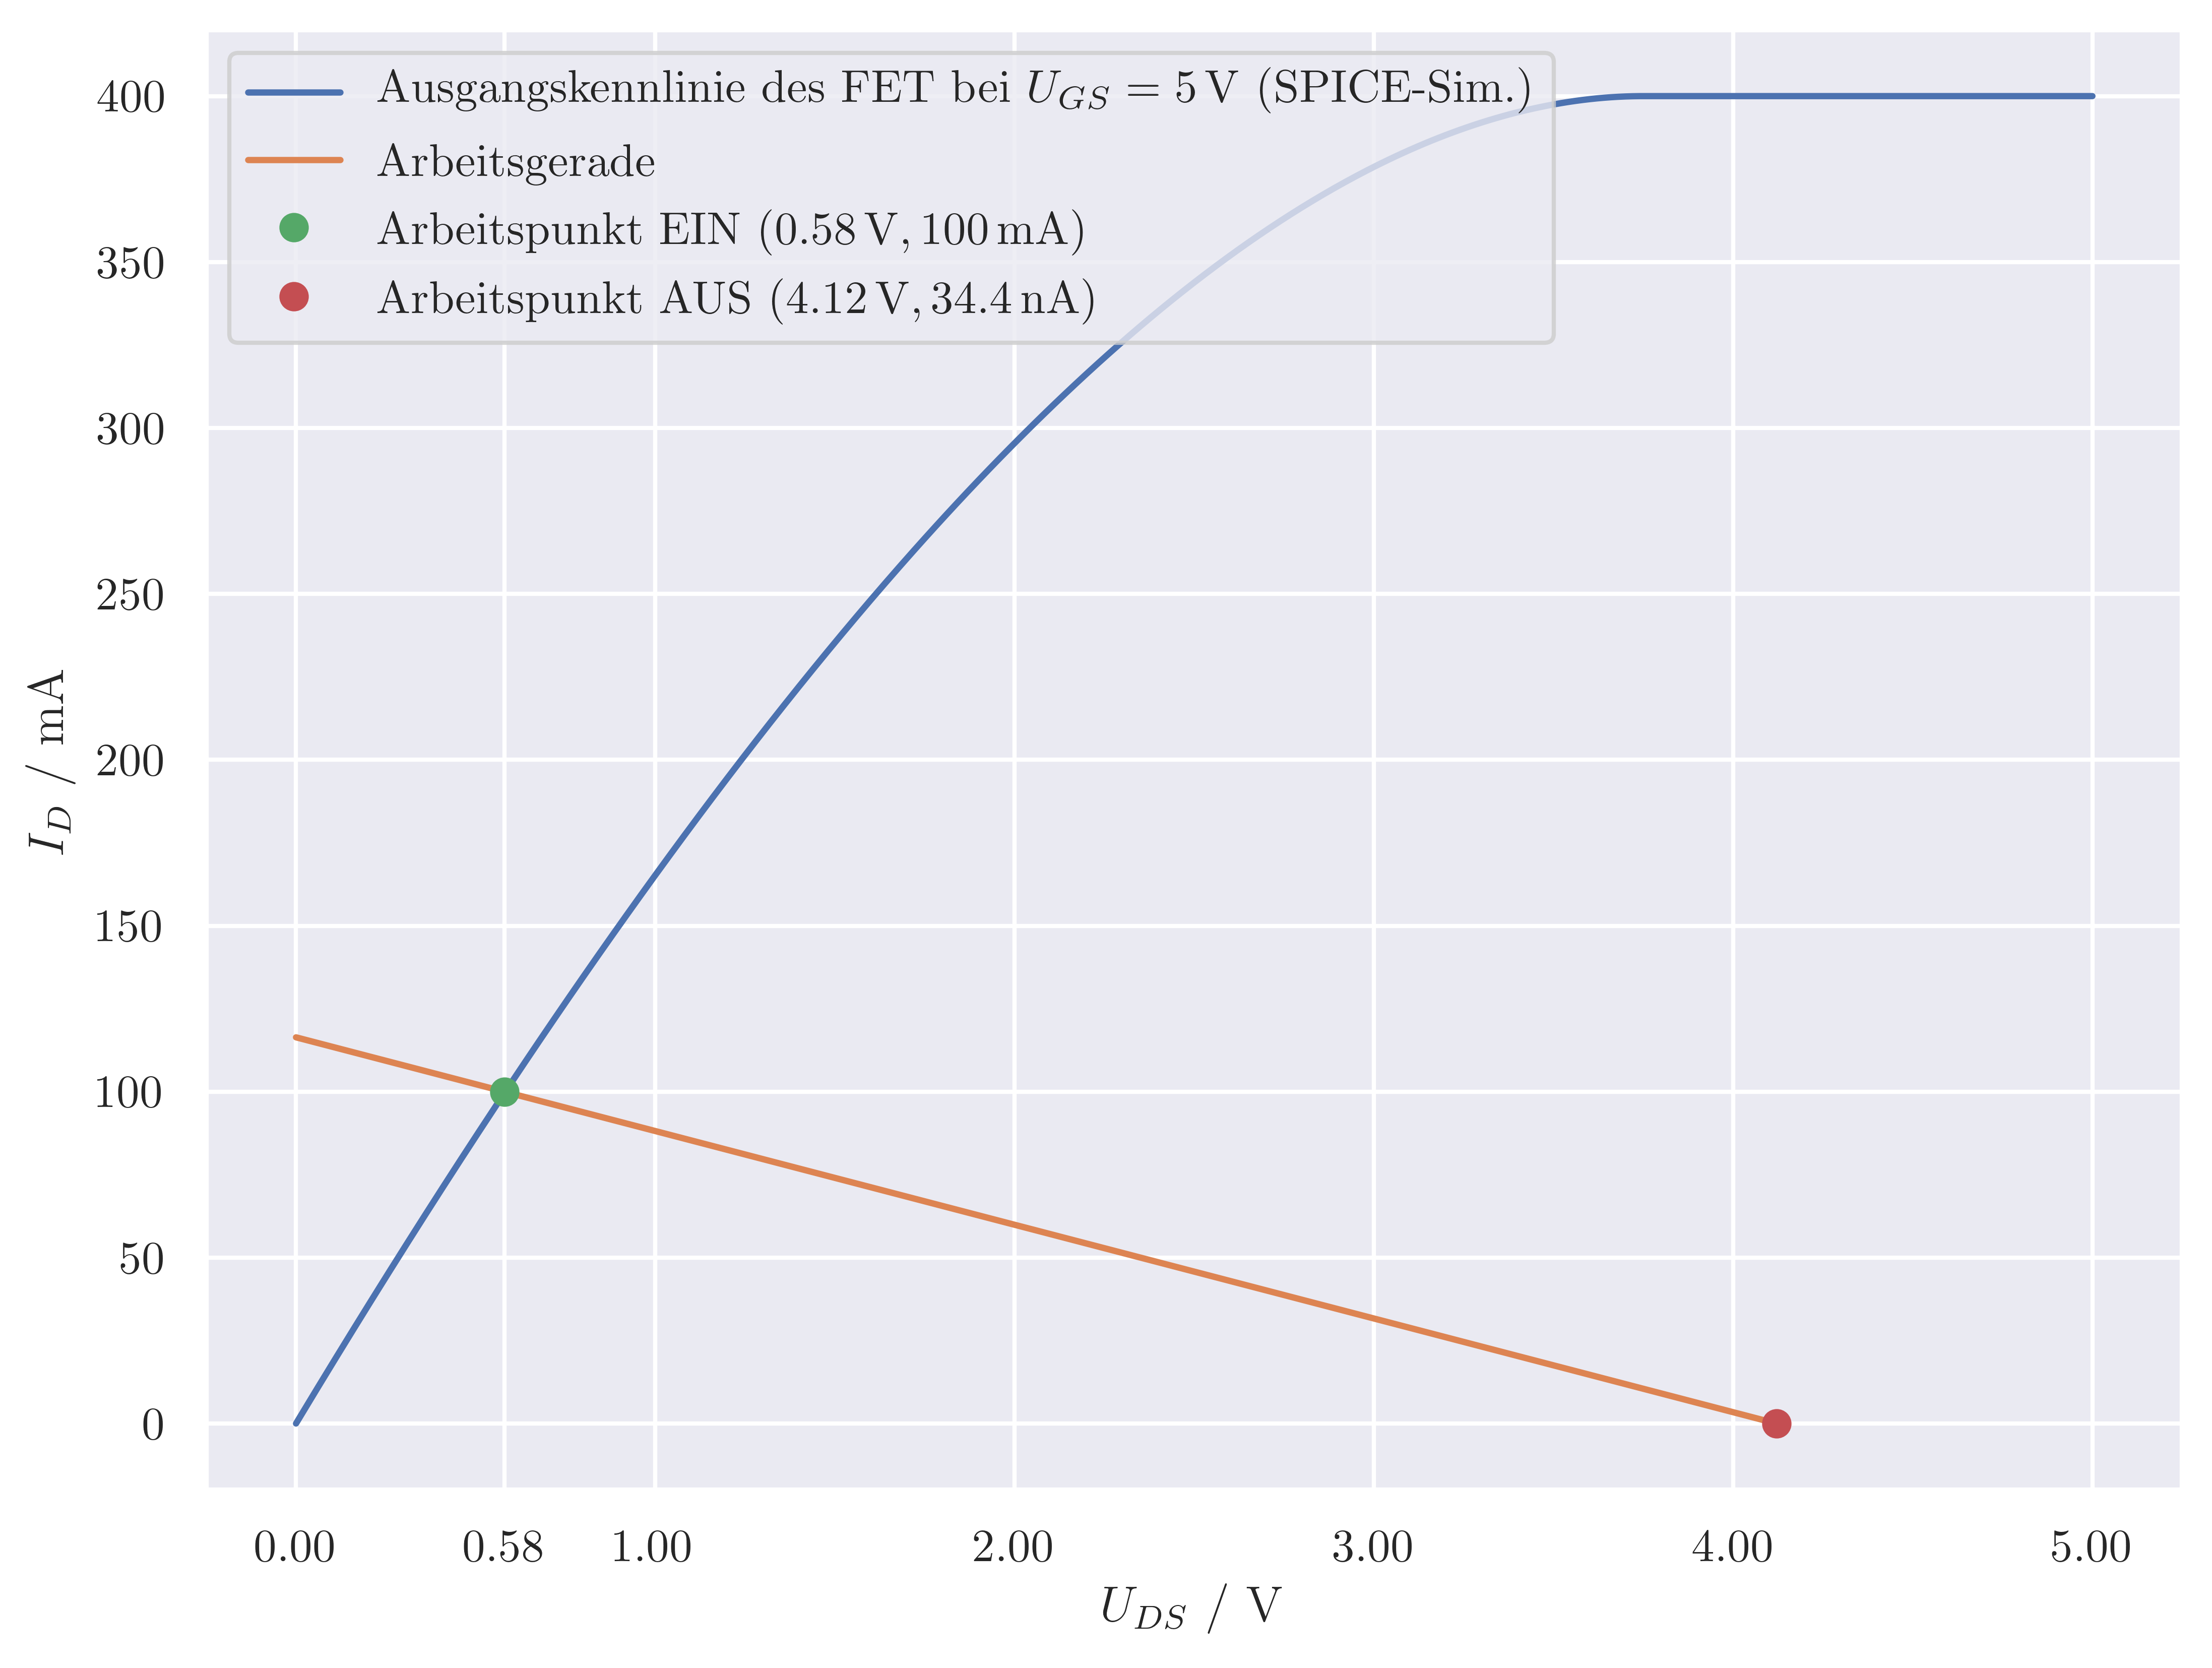

In [6]:
# AKF, Arbeitsgerade
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(afk_on[:, 0], afk_on[:, 1]*1000, label=r"Ausgangskennlinie des FET bei $U_{GS} = \SI{5}{\V}$ (SPICE-Sim.)")
p = 100 + (100 - points[-1, 1])/(points[-1, 0] - 0.58)*0.58
ax.plot([0, points[-1, 0]], [p, points[-1, 1]], label='Arbeitsgerade')
ax.plot([0.58], [100], 'o', label=r'Arbeitspunkt EIN $(\SI{0.58}{\V}, \SI{100}{\mA})$')
ax.plot(points[-1, 0], points[-1, 1], 'o', label=r'Arbeitspunkt AUS $(\SI{4.12}{\V}, \SI{34.4}{\nA})$')
ax.set_xticks(list(range(6)) + [0.58])
ax.set(xlabel='$U_{DS}$ / V', ylabel='$I_D$ / mA')#, title="Bestimmung der Arbeitspunkte im Ausgangskennlinienfeld ($U_{GS} = \SI{5}{\V}$)")
ax.legend(loc='upper left')

#fig.tight_layout()
fig.savefig('AKF.png')

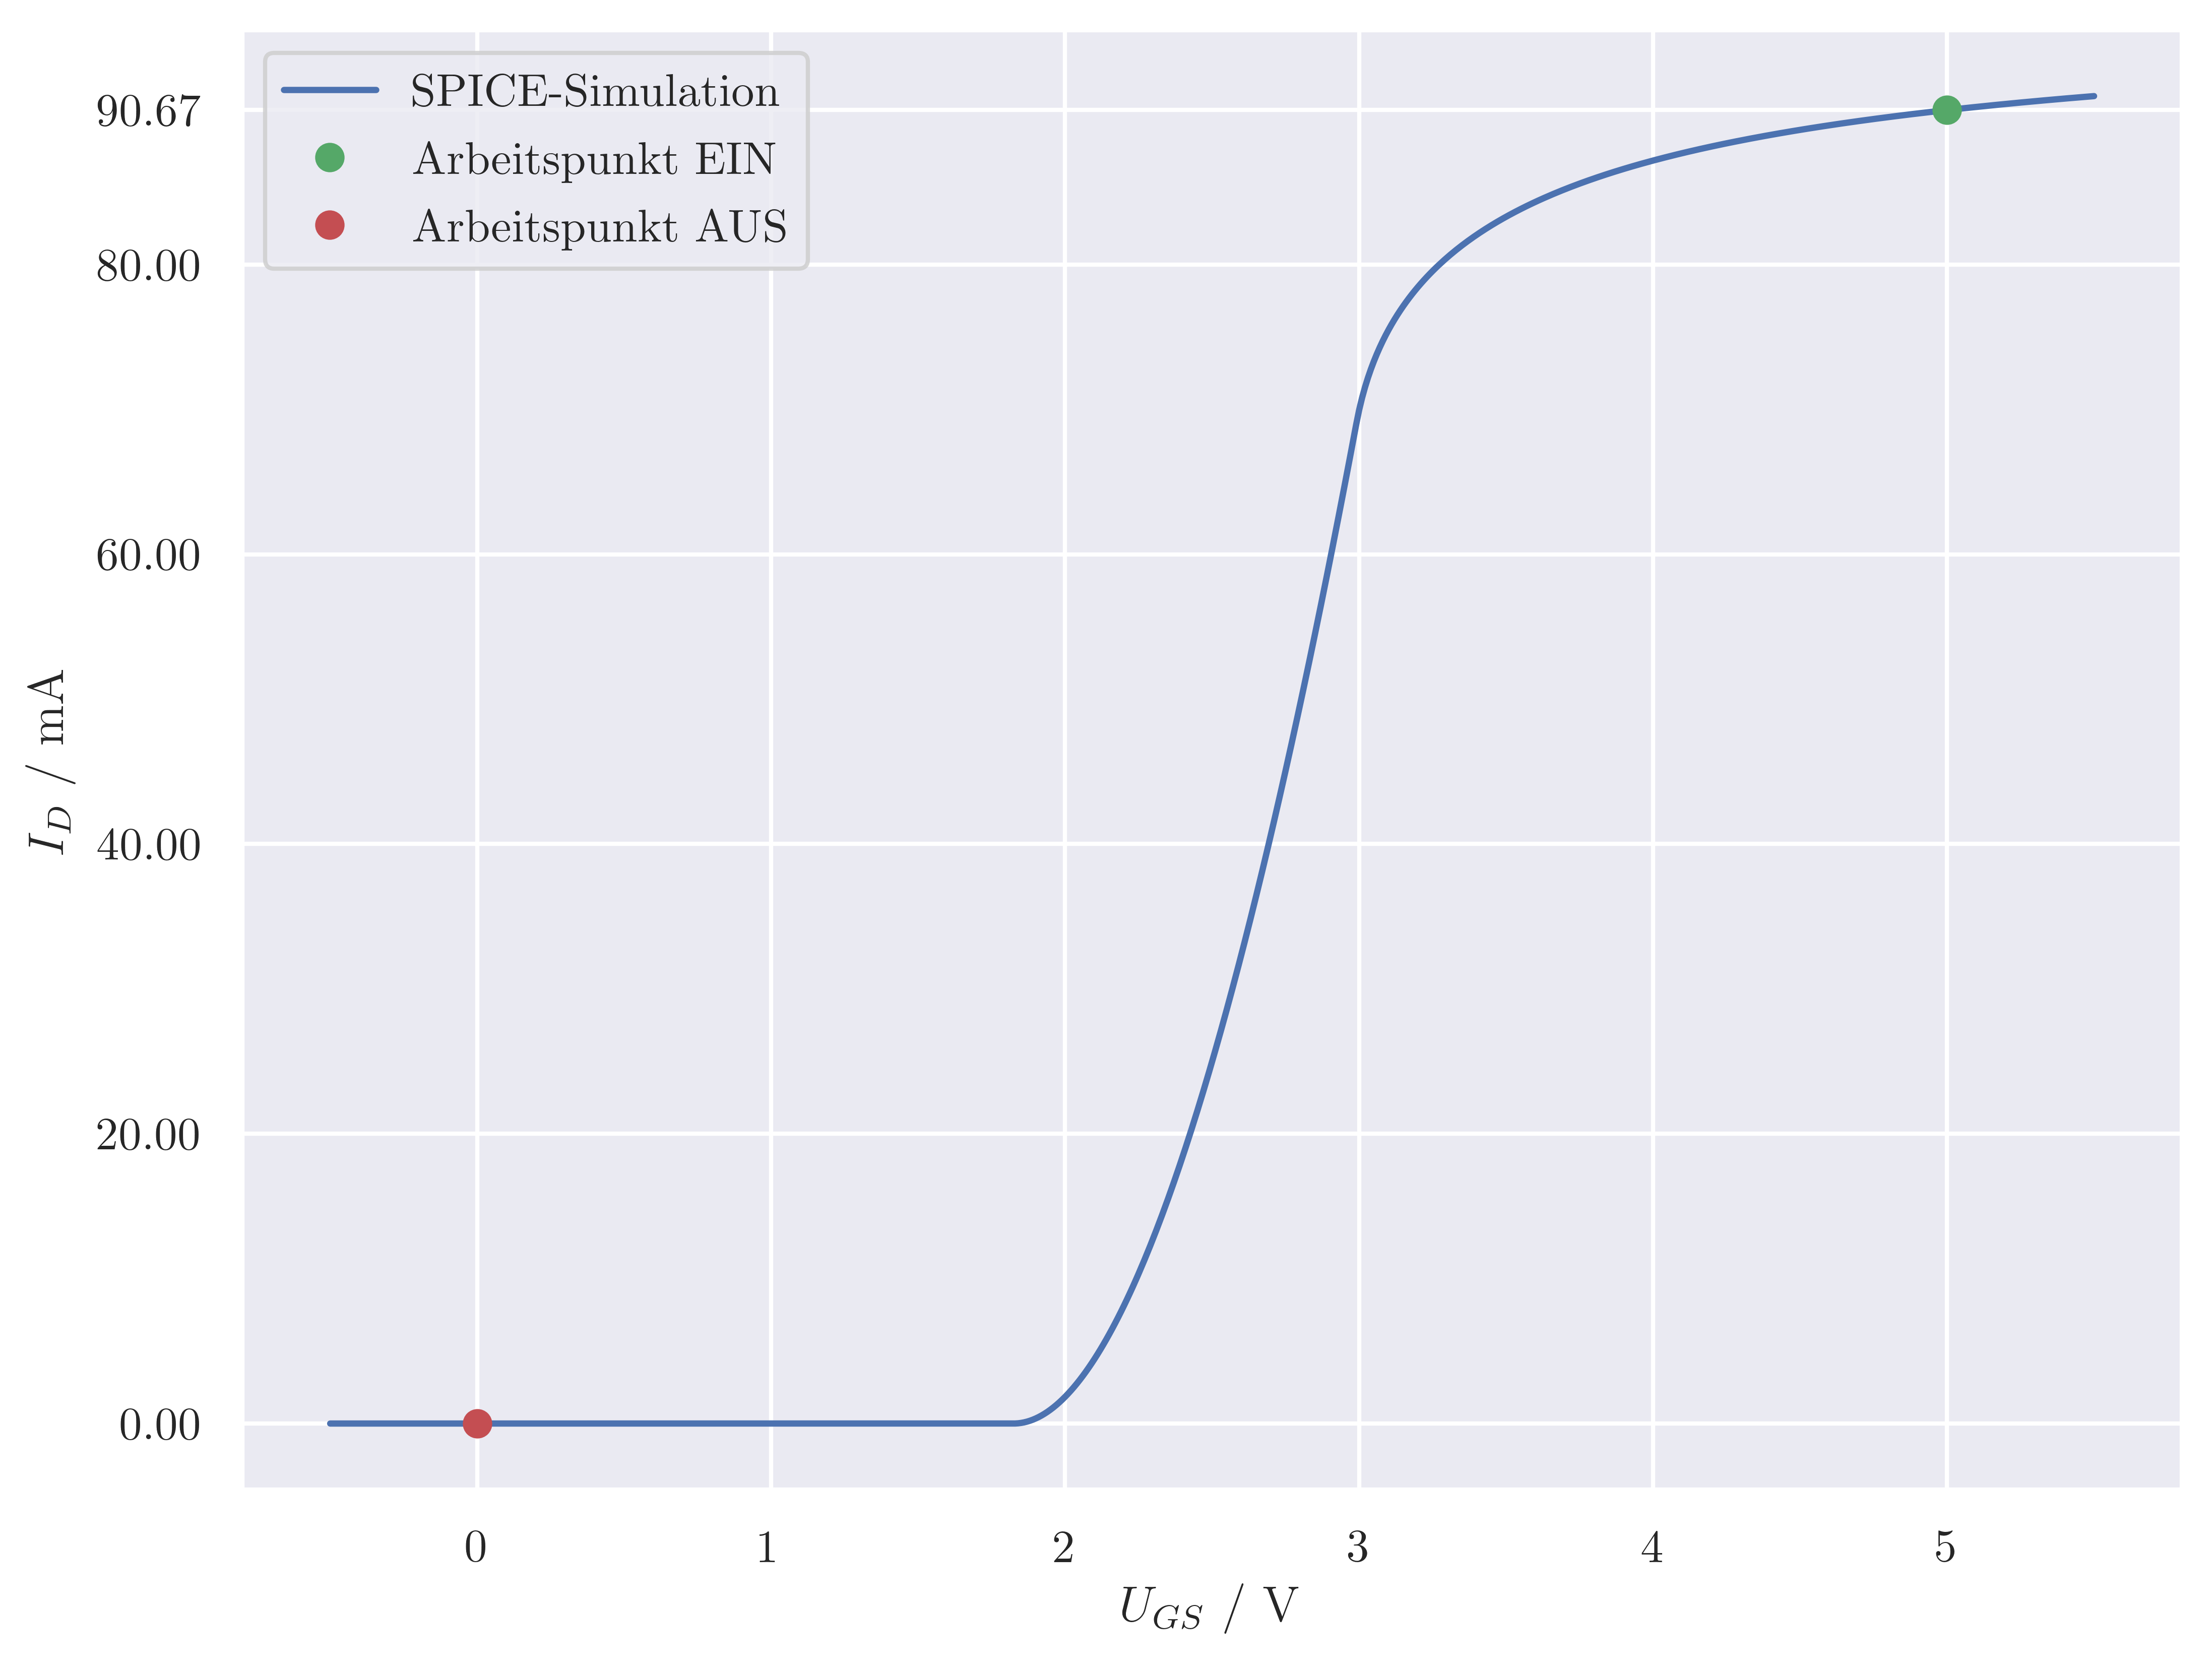

In [7]:
# Schaltverhalten
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(operation[:, 0], operation[:, 1]*1000, label="SPICE-Simulation")
ax.plot([5], [90.67], 'go', label='Arbeitspunkt EIN')
ax.plot([0], [0], 'ro', label='Arbeitspunkt AUS')
ax.set_yticks(list(range(0, 90, 20)) + [90.67])
ax.set(xlabel='$U_{GS}$ / V', ylabel='$I_D$ / mA')#, title="Schaltverhalten mit $R = 33\Omega$ bei $U_0 = 5$V")
ax.legend()

#fig.tight_layout()
fig.savefig('sim.png')

$$
\begin{align}
R &= \frac{U_0 - U_{D,AP} - U_{DS,AP}}{I_{D, max}}\\
  &= \frac{5\text{V} - 1.495\text{V} - 0.58\text{V}}{100\text{mA}}\\
  &= 29.25\Omega
\end{align}
$$

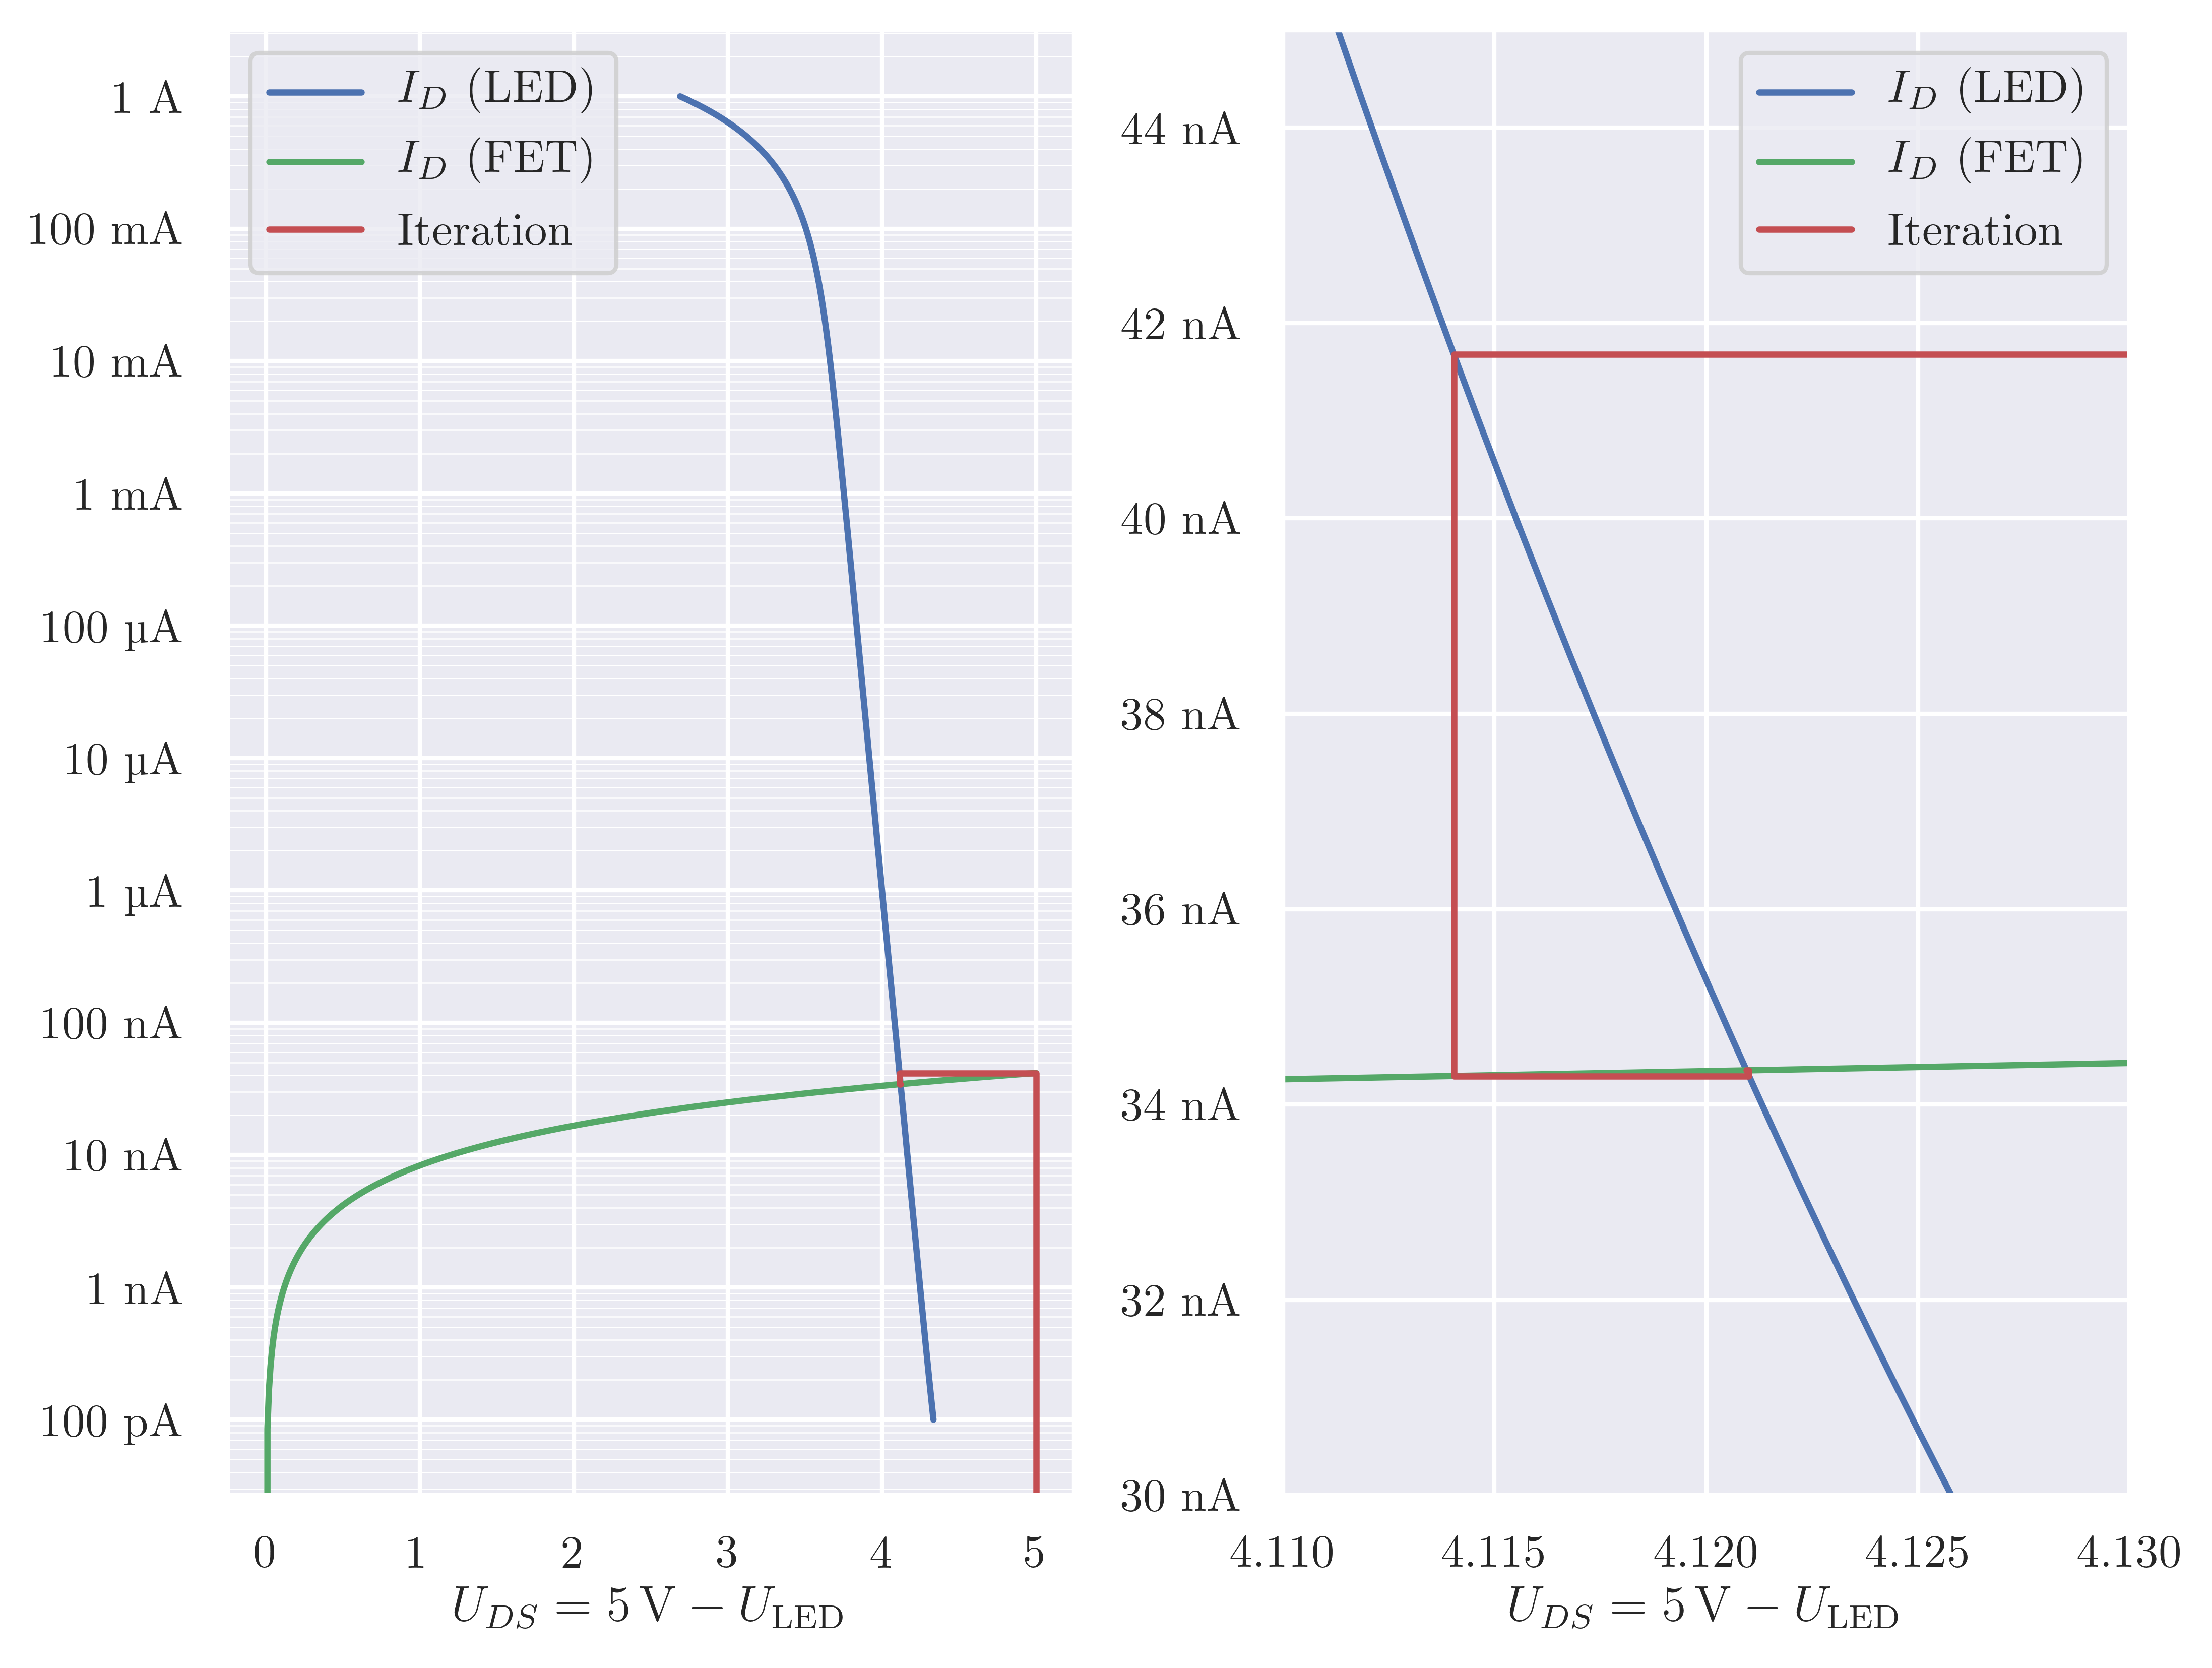

In [8]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)

#fig.suptitle("Iteratives Bestimmen des AUS-Arbeitspunktes")#, size=mpl.rcParams['axes.titlesize'])

ax[0].semilogy(5 - ledvi[:, 1], ledvi[:, 0], label="$I_{D}$ (LED)")
ax[0].semilogy(afk_off[:, 0], afk_off[:, 1], "C2", label="$I_D$ (FET)")
ax[0].step(points[:, 0], points[:, 1], 'C3', label="Iteration")
ax[0].set_xticks(np.arange(0, 6))
ax[0].set_yticks(10.**np.arange(-10, 1))
ax[0].yaxis.grid(True, which='minor', linewidth=.3)
ax[0].yaxis.set_minor_locator(mpl.ticker.LogLocator(base=10. ,subs=(.1, .2, .3, .4, .5, .6, .7, .8, .9), numticks=12))
ax[0].yaxis.set_major_formatter(EngFormatter(unit="A", places=0))
ax[0].set_xlabel("$U_{DS} = \SI{5}{\V} - U_{\mathrm{LED}}$")
ax[0].legend(loc='upper left')

ax[1].plot(5 - ledvi[:len(ledvi)//2, 1], ledvi[:len(ledvi)//2, 0], label="$I_{D}$ (LED)")
ax[1].plot(afk_off[len(afk_off)//2:, 0], afk_off[len(afk_off)//2:, 1], "C2", label="$I_D$ (FET)")
ax[1].step(points[:, 0], points[:, 1], 'C3', label="Iteration")
ax[1].yaxis.set_major_formatter(EngFormatter(unit="A", places=0))
ax[1].set_xlim(4.11, 4.13)
ax[1].set_ylim(3e-8, 4.5e-8)
ax[1].set_xlabel("$U_{DS} = \SI{5}{\V} - U_{\mathrm{LED}}$")
ax[1].legend(loc='upper right')

#fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.savefig('iteration.png')